# MA060129, Bayesian Machine Learning Homework 3: Practical Problems

#### List of problems:
[Task 1](#Task1) 30 points

[Task 2](#Task2) 15 points

[Task 3](#Task3) 5 points 

[Task 4](#Task4) 10 points 

------ Total : 60 points  -------

[Bonus](#Bonus) 20 point

## Variational Autoencoders

VAEs consider two-step generative process by a prior over latent space $p(z)$ and a conditional generative distribution $p_{\theta}(x|z)$, which is parametrized by a deep neural network (DNN). Our goal is to maximize marginal log-likehood  which is intractable in general case. Therefore, variational inference (VI) framework is considered.

\begin{equation*}
    \begin{aligned}
    & \log p(x) \geq \mathcal{L}(x;\theta;q) = \mathbb{E}_{z\sim q(z)}[\log p_{\theta}(x|z)] - \text{KL}[q(z)\|p(z)],
    \end{aligned}
\end{equation*}

where $q(z|x)$ is a variational posterior distribution. Given data distribution $p_e(x) = \frac1N\sum_{i=1}^N \delta_{x_i}(x)$ we aim at maximizing the average marginal log-likelihood. Following the variational auto-encoder architecture amortized inference is proposed by choice of the variational distribution $q_{\phi}(z|x)$ which is also parametrized by DNN.

\begin{equation*}
    \begin{aligned}
    & \arg\max\limits_{\phi, \theta}\mathbb{E}_{x}\mathcal{L}(x,\phi,\theta)=\arg\max\limits_{\phi, \theta}\mathbb{E}_{x}\mathbb{E}_{z\sim q(z)}[\log p_{\theta}(x|z)] - \mathbb{E}_x \text{KL}[q_{\phi}(z|x)\|p(z)].
    \end{aligned}
\end{equation*}

To evaluate the performance of the VAE approach, we will estimate a negative log likelihood (NLL) on the test set. NLL is calculated by importance sampling method:
\begin{equation*}
   - \log p(x) \approx - \log \frac{1}{K} 
   \sum_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)},\,\,\,\,z_i \sim q_\phi(z | x).     
\end{equation*}

### References
1. Auto-Encoding Variational Bayes https://arxiv.org/pdf/1312.6114.pdf
2. Beta-VAE https://pdfs.semanticscholar.org/a902/26c41b79f8b06007609f39f82757073641e2.pdf
3. Importance Weighted Autoencoders https://arxiv.org/pdf/1509.00519.pdf 

## VAE
Below you can find emty class for VAE model. It contians methods, which will help you to make all the tasks in this asignment. You can use code from the VAE seminar to implement the methods, if you use other sources, provide the reference, please.

In [20]:
import gdown
gdown.download(id='1CsDMOIGEsD1l3BLhuQDfEfEmLEb83wMz', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CsDMOIGEsD1l3BLhuQDfEfEmLEb83wMz
To: /home/jupyter/work/resources/dots.zip
100%|██████████| 1.58G/1.58G [00:27<00:00, 57.7MB/s]


'dots.zip'

In [1]:
import math 
import torch
def log_gaussian(x, mean, logvar, dim=None):
    log_normal = -0.5 * (math.log(2.0*math.pi) + logvar + 
                         torch.pow(x - mean, 2) / (logvar.exp()+1e-5))
    return log_normal.sum(dim)

In [2]:
import numpy as np
import torch.nn as nn

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image

class ReshapeIdx(nn.Module):
    def __init__(self, idx, shape):
        super().__init__()
        self.idx = idx
        self.shape = shape
        
    def forward(self, x):
        return x.reshape([x.shape[self.idx]] + list(self.shape))


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

class VAE(nn.Module):
    def __init__(self, z_dim, hid_dim, input_shape):
        """
        z_dim: int, dimention of the latent space
        input_shape: (3, x_dim, x_dim)
        """
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.hid_dim = hid_dim
        x_dim = np.prod(input_shape)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, 4, 2),
            nn.LeakyReLU(0.1),
            Flatten(),
            nn.Linear(25088, hid_dim),
            nn.LeakyReLU(0.1),
        )

        self.mu = nn.Linear(hid_dim, z_dim)
        self.logsigma = nn.Linear(hid_dim, z_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 13*13*128),
            nn.ReLU(),
            ReshapeIdx(0, (128,13,13)),
            nn.ConvTranspose2d(128, 64, 4, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2),
            nn.Sigmoid()
        )
       
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight.data)
        
    def q_z(self, x):
        """
        VARIATIONAL POSTERIOR
        :param x: input image
        :return: parameters of q(z|x), (MB, hid_dim)
        """
        hidden = self.encoder(x)
        mu = self.mu(hidden)
        logsigma = self.logsigma(hidden)
        return mu, logsigma

    def p_x(self, z):
        """
        GENERATIVE DISTRIBUTION
        :param z: latent vector          (MB, z_dim)
        :return: parameters of p(x|z)    (MB, x_dim)
        """
        return self.decoder(z)

    def forward(self, x):
        """
        Encoder the image, sample z and decode 
        :param x: input image
        :return: parameters of p(x|z_hat), z_hat, parameters of q(z|x)
        """
        z_mu, z_logsigma = self.q_z(x)
        z_ = self.reparametrize(z_mu, z_logsigma)
        x_ = self.p_x(z_)
        return x_, z_, z_mu, z_logsigma

    def log_p_z(self, z):
        """
        Log density of the Prior
        :param z: latent vector     (MB, z_dim)
        :return: \sum_i log p(z_i)  (1, )
        """
        return z.pow(2).mul(-0.5).sum(-1)

    def reconstruct_x(self, x):
        x_mean, _, _, _ = self.forward(x)
        return x_mean

    def kl(self, z, z_mean, z_logsigma):
        """
        KL-divergence between p(z) and q(z|x)
        """
        kl = (z_mean.pow(2) + torch.exp(2 * z_logsigma) - 1 - 2 * z_logsigma).mul(0.5)
        return kl.sum(1).mean()

    def calculate_loss(self, x, beta=1.):
        """
        Given the input batch, compute the negative ELBO 
        :param x:   (MB, inp_dim)
        :param beta: Float
        :return: nll + beta * KL  (MB, ) or (1, )
        """
        x_mu, z_sample, z_mu, z_logsigma = self.forward(x)
        KL = self.kl(z_sample, z_mu, z_logsigma)
        nll = (x_mu - x).pow(2).sum(3).sum(2).sum(1).mean()
        return nll + beta * KL, nll, KL

    def calculate_nll(self, X, K=100):
        """
        Estimate NLL by importance sampling 
        (see VAE seminar, but be carefull with dimetions)
        :param X: dataset, (N, 3, 64, 64)
        :param samples: Samples per observation
        :return: IS estimate
        """
        N = X.shape[0]
        z_mu, z_logsigma = self.q_z(X)
        z_sample = self.reparametrize(z_mu.repeat((K, 1, 1)), z_logsigma.repeat((K, 1, 1)))
        log_p = self.log_p_z(z_sample)
        log_q = (2 * z_logsigma.unsqueeze(0) + (z_sample - z_mu.unsqueeze(0)).pow(2) / torch.exp(2 * z_logsigma.unsqueeze(0))).mul(-0.5).sum(-1)
        x_mu = self.p_x(z_sample.reshape(N*K, -1))
        probs = torch.clamp(x_mu.reshape(K, N, -1), min=1e-5, max=1.-1e-5)
        log_p_x = (X.reshape(1, N, -1) * torch.log(probs) + (1. - X.reshape(1, N, -1)) * torch.log(1. - probs)).sum(-1)
        log_lik = torch.logsumexp(log_p_x + log_p - log_q, 0) - np.log(K)
        return log_lik.data.cpu()

    def generate_x(self, N=25):
        """
        Sample, using you VAE: sample z from prior and decode it 
        :param N: number of samples
        :return: X (N, inp_size)
        """
        z = torch.randn((N, self.z_dim), device=device)
        return self.p_x(z)

    @staticmethod
    def reparametrize(mu, logsigma):
        std = torch.exp(logsigma)
        eps = torch.FloatTensor(std.size()).normal_().to(mu.device)
        return eps.mul(std).add_(mu)

## Generalization

The size of the Dataset, that is used to train generative model is often exponentially small compared to the support of density $p(x)$. Thus, it is important to be able to evaluate genralization abilities of the learned model.

In this assignment you will be asked to evaluate generalization ability of the VAE, using the approach discussed in https://arxiv.org/abs/1811.03259. 

Authors propose to study the generalization ability of the generative model, using **probing features** - functions which map image to a value. E.g., number of objects on the images.


We will use the dataset with dots, which can be downloaded [here](https://drive.google.com/open?id=1CsDMOIGEsD1l3BLhuQDfEfEmLEb83wMz). 

---
<a id='Task1'></a>
**Task 1. [30 pts]: Training**
* Train your VAE on the **subset** of images contating only 3 dots (use batch 0-5 for training and leave 6 and 7 for validation). 
* Plot ELBO vs Iteration, KL vs Iteration and NLL vs Iteration during training.
* Plot 10 pairs of `image`-`reconstruction` for 10 random images from the validation dataset 
* Plot 10 samples from the model

Note, that the task is considered completed only if your model produces reasonable **reconstructions** and **samples**. By resonable I mean:
- Reconstructions and true images have the same number of dots of similar colors
- Samples have dots of different colors on them (they may not have perfect shapes)

---
Some hints, that might be usefull (you do not have to use all of them):
- Use CNNs for encoder and decoder
- Use gaussian distribution for $p(x|z)$
- **Fix** variance of the $p(x|z)$ and train only mean value (aka NLL is MSE loss)
- Scale pixels of the input (dataset) and output (generated) images to [-1,1] range
- Use `Upsample` + `Conv` instead of `ConvTranspose` in the decoder
- Use $\beta$-VAE objective instead of simple ELBO:
    $$ -NLL + \beta \text{KL}(q(z|x)\|p(z))$$
$\beta$ is a hyperparameter. You can either fix it, or use so-called $\beta$-annealing. In the latter case, we gradually increase the value of $\beta$ from 0 during training.
- If reconstructions look nice but samples are bad, you probably need to put more weight on the KL-term  (larger $\beta$)

+ other standard DL tricks, e.g. lr annealing, early stopping, augmentations, etc.
---

In [4]:
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
# Load the data, define train and validation datasets
class DotsDataset(Dataset):
    def __init__(self, path, transform=None):
        files = glob.glob(path, recursive=True)
        images = []
        for f in files:
            np_batch = np.load(f)['images']
            images.append(torch.Tensor(np_batch))
        self.images = torch.cat(images)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        img = self.images[item]
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([Rescale()])
train_data = DotsDataset('dots/3_dots/*[0-5].npz',transform=transform)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

Epoch 138


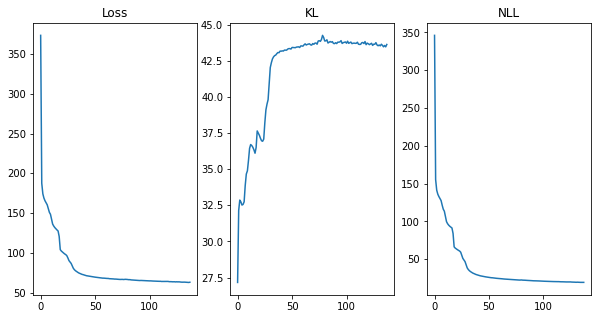

In [6]:
# Training VAE (do not forget to save checkpoint, 
# and send it along with HW solution)
max_epoch = 138
vae = VAE(100, 1024, (64, 64,3)).to(device)

kl_hist = []
nll_hist = []
loss_hist = []

optimizer = torch.optim.Adam(vae.parameters(), betas=(0.5, 0.9), lr=1e-4)
vae.train()
for e in range(max_epoch):
    print(f"Epoch {e+1}")
    total_loss = 0.
    total_kl = 0.
    total_nll = 0.
    for X in tqdm(train_loader):
        optimizer.zero_grad()
        X = X.permute(0,3,1,2).to(device)
        loss, nll, kl = vae.calculate_loss(X)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_kl += kl.item()
        total_nll += nll.item()

    total_loss /= len(train_loader)
    total_kl /= len(train_loader)
    total_nll /= len(train_loader)
    kl_hist.append(total_kl)
    loss_hist.append(total_loss)
    nll_hist.append(total_nll)

    fig, ax = plt.subplots(ncols=3, figsize=(10,5))
    ax[0].plot(loss_hist)
    ax[0].set_title('Loss')
    ax[1].plot(kl_hist)
    ax[1].set_title('KL')
    ax[2].plot(nll_hist)
    ax[2].set_title('NLL')
    plt.pause(0.3);
    clear_output(wait=True);

In [6]:
torch.save({
            'epoch': max_epoch,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_hist[-1],
            'kl': kl_hist[-1],
            'nll': nll_hist[-1],
            }, 'vae.pth')

In [ ]:
# Plot reconstructions

In [7]:
vae.eval()
val_data = DotsDataset('dots/3_dots/*[6-7].npz', transform=transform)
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)
with torch.no_grad():
    batch = next(iter(val_loader)).permute(0,3,1,2).to(device)
    reconstructions = vae.reconstruct_x(batch)

batch = batch.cpu().permute(0, 2, 3, 1)
reconstructions = reconstructions.cpu().permute(0, 2, 3, 1)

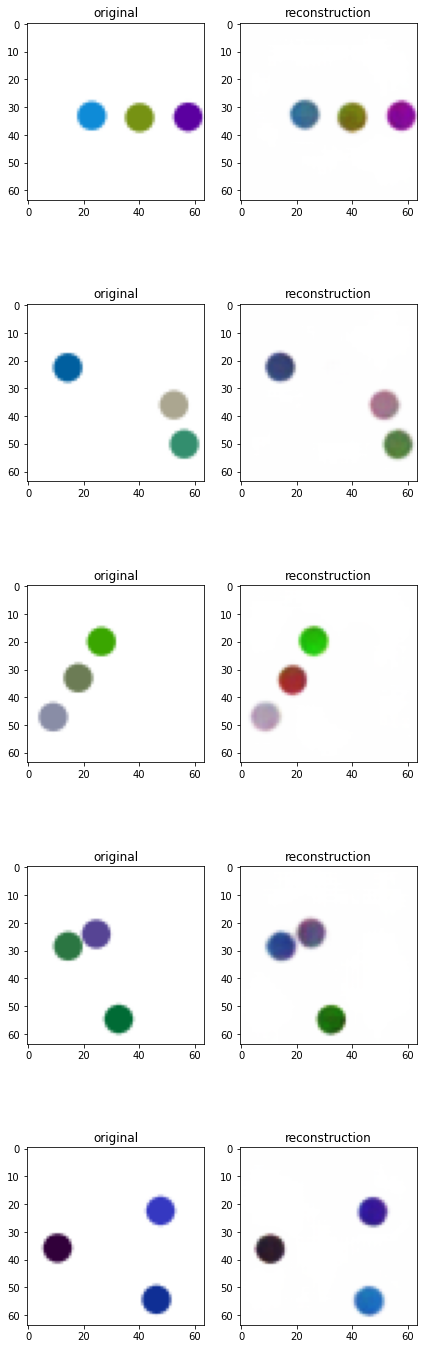

In [8]:
fig, ax = plt.subplots(5, 2, figsize=(7,25))
for i in range(5):
    ax[i][0].imshow(batch[i])
    ax[i][1].imshow(reconstructions[i])
    ax[i][0].set_title('original')
    ax[i][1].set_title('reconstruction')

plt.show()

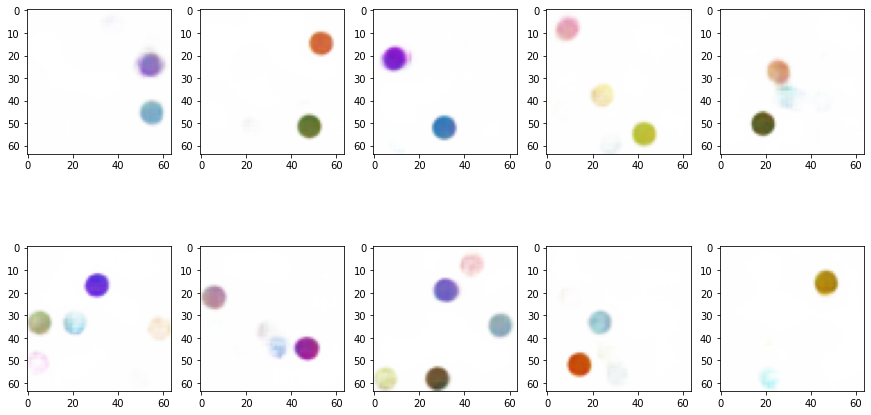

In [12]:
vae.eval()
with torch.no_grad():
    samples = vae.generate_x(10).cpu().permute(0, 2, 3, 1)

fig, ax = plt.subplots(2, 5, figsize=(15,8))
for i in range(10):
    ax[i//5][i%5].imshow(samples[i])
plt.show()

---
<a id='Task2'></a>
**Task 2. [15 pts]: Evaluation**

Calculate NLL on a validation set, contating only 3 dots. 

In [15]:
def eval_loglik(vae, val_loader, K=100):
    curr = []
    with torch.no_grad():
        for X in tqdm(val_loader):
            curr.append(vae.calculate_nll(X.permute(0,3,1,2).to(device), K))
        return -torch.cat(curr).mean().item()

val_data = DotsDataset('dots/3_dots/*[6-7].npz', transform=transform)
val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
eval_loglik(vae, val_loader=val_loader)

533.4727172851562

---
<a id='Task2'></a>
**Task 3. [5 pts]: Generalization [1]**

* Sample 25 images from the VAE and draw them on the 5 $\times$ 5 grid. 
* What can you say abuout generalization ability of the model based the results

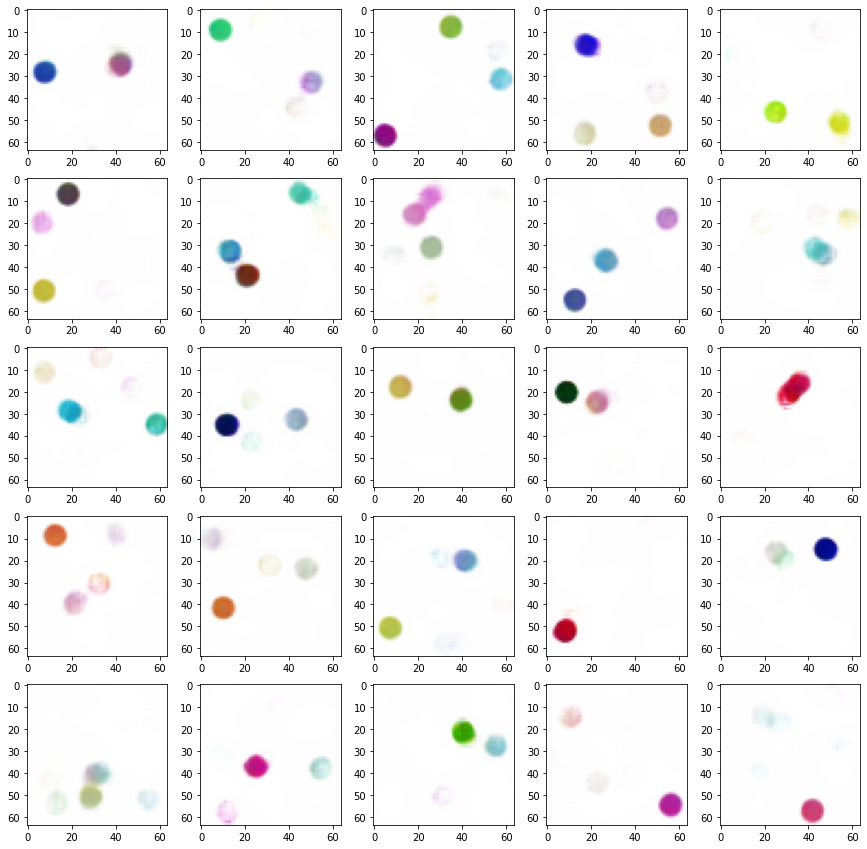

In [16]:
# Sampling
vae.eval()
with torch.no_grad():
    samples = vae.generate_x(25).cpu().permute(0, 2, 3, 1)

fig, ax = plt.subplots(5, 5, figsize=(15,15))
for i in range(25):
    ax[i//5][i%5].imshow(samples[i])
plt.show()

Well, I can say that the generalization ability of the model is pretty good. Despite the fact that it was trained only on 3-dots dataset, it can produce different numbers of dots as wel as different colors.

--- 
<a id='Task4'></a>
**Task 4. [10 pts]: Generalization [2]** 

* Define 2 new validation sets: containing only 2 dots (batches 6 and 7) and only 4 dots (batches 6-7) 
* Plot reconstruction of 10 random from both dataset
* Compute NLL of your VAE on these datasets
* What can you say about generalization ability of the model based the results


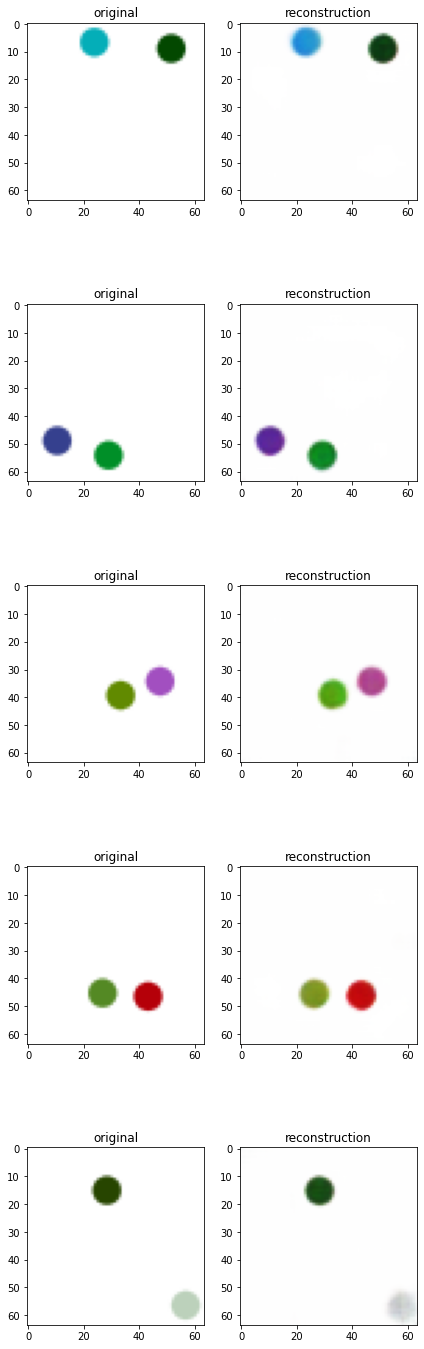

In [17]:
# reconstruction plots, 2 dots
vae.eval()
val_data = DotsDataset('dots/2_dots/*[6-7].npz', transform=transform)
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)
with torch.no_grad():
    batch = next(iter(val_loader)).permute(0,3,1,2).to(device)
    reconstructions = vae.reconstruct_x(batch)

batch = batch.cpu().permute(0, 2, 3, 1)
reconstructions = reconstructions.cpu().permute(0, 2, 3, 1)

fig, ax = plt.subplots(5, 2, figsize=(7,25))
for i in range(5):
    ax[i][0].imshow(batch[i])
    ax[i][1].imshow(reconstructions[i])
    ax[i][0].set_title('original')
    ax[i][1].set_title('reconstruction')

plt.show()

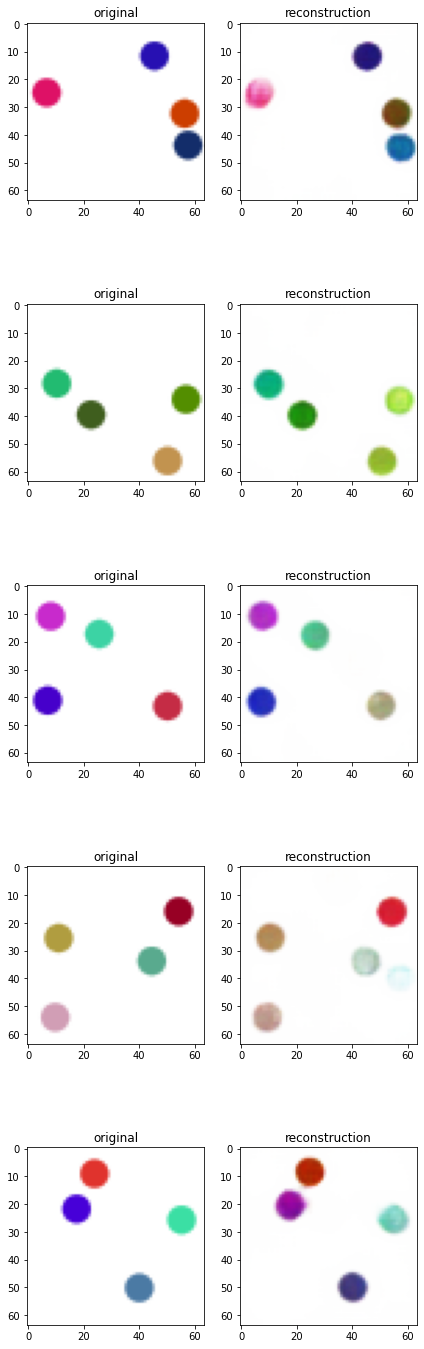

In [18]:
# reconstruction plots, 4 dots
vae.eval()
val_data = DotsDataset('dots/4_dots/*[6-7].npz', transform=transform)
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)
with torch.no_grad():
    batch = next(iter(val_loader)).permute(0,3,1,2).to(device)
    reconstructions = vae.reconstruct_x(batch)

batch = batch.cpu().permute(0, 2, 3, 1)
reconstructions = reconstructions.cpu().permute(0, 2, 3, 1)

fig, ax = plt.subplots(5, 2, figsize=(7,25))
for i in range(5):
    ax[i][0].imshow(batch[i])
    ax[i][1].imshow(reconstructions[i])
    ax[i][0].set_title('original')
    ax[i][1].set_title('reconstruction')

plt.show()

In [19]:
# NLL
val_data = DotsDataset('dots/2_dots/*[6-7].npz', transform=transform)
val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
print(f"NLL for 2_dots: {eval_loglik(vae, val_loader=val_loader)}")

val_data = DotsDataset('dots/4_dots/*[6-7].npz', transform=transform)
val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
print(f"NLL for 4_dots: {eval_loglik(vae, val_loader=val_loader)}")


NLL for 2_dots: 359.5157470703125

NLL for 4_dots: 758.2788696289062


I still think that the model is good at generalization criteria. It reconstructed 2-dots even better than 3-dots, and 4-dots reconstruction is more less sufficient (in spite of little color mess).

<a id='Bonus'></a>
## Bonus task [20 pts]

Assume that we want to quantify the generalization ability of the model. To do that, we need to accurately compute number of dots on all the generated images.

1. Train neural network, which will classify images based on number of dots with high probability (>95%)
2. Generate 10'000 images from you VAE
3. Classify generated images and plot the histogram

In [4]:
#train on batches 0-3, validate on 4 (no more data fits into memory)
import torchvision.transforms as transforms
from PIL import Image

class DotsDataset(Dataset):
    def __init__(self, path, transform=None):
        files = glob.glob(path, recursive=True)
        images = []
        dots_num = []
        for f in files:
            np_batch = np.load(f)['images']
            images.append(torch.Tensor(np_batch).permute(0,3,1,2))
            num = int(f.split('/')[1].split('_')[0]) - 1
            dots_num.append(torch.ones(np_batch.shape[0]) * num)
        self.images = torch.cat(images)
        self.dots_num = torch.cat(dots_num)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        img = self.images[item]
        if self.transform:
            img = self.transform(img)
        return img, self.dots_num[item]

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.Normalize([0.9703, 0.9705, 0.9701], [0.1376, 0.1375, 0.1382])])
test_transform = transforms.Compose([transforms.Normalize([0.9703, 0.9705, 0.9701], [0.1376, 0.1375, 0.1382])])
train_data = DotsDataset('dots/*/*[0-3].npz',transform=train_transform)
val_data = DotsDataset('dots/*/*[4].npz',transform=test_transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
import torchvision.models as models

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extractor = models.resnet18(pretrained=True)
        self.linear = torch.nn.Linear(self.feature_extractor.fc.out_features, 12, bias=False)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.linear(x)
        return x

resnet18 = Model().to(device)

optimizer = torch.optim.Adam(resnet18.parameters(), betas=(0.9, 0.999), lr=5e-4)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

for e in range(3):
    print(f"Epoch {e+1}")
    total_loss = 0.
    resnet18.train()
    for X, y  in tqdm(train_loader):
        optimizer.zero_grad()
        X = X.to(device)
        y = y.long().to(device)
        output = resnet18(X)
        loss = criterion(output, y).sum()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    lr_scheduler.step()

    total_loss /= len(train_loader)
    clear_output(wait=True)
    print("Training loss {0:0.4f}".format(total_loss))
    resnet18.eval()
    total_acc = 0.
    with torch.no_grad():
        for X, y  in tqdm(val_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.long().to(device)
            output = resnet18(X)
            preds = output.argmax(dim=1)
            total_acc += (preds == y).sum().item()
    total_acc /= len(val_data)
    print("Validation accuracy {0:0.0f} %".format(total_acc*100))

In [11]:
resnet18.eval()
total_acc = 0.
with torch.no_grad():
    for X, y  in tqdm(val_loader):
        optimizer.zero_grad()
        X = X.to(device)
        y = y.long().to(device)
        output = resnet18(X)
        preds = output.argmax(dim=1)
        total_acc += (preds == y).sum().item()
total_acc /= len(val_data)
print("Validation accuracy {0:0.0f} %".format(total_acc*100))


Validation accuracy 100 %


In [8]:
torch.save({
            'model_state_dict': resnet18.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'resnet18.pth')

In [9]:
vae = VAE(100, 1024, (64, 64,3)).to(device)
checkpoint = torch.load('vae.pth')
vae.load_state_dict(checkpoint['model_state_dict'])
vae.eval()
with torch.no_grad():
    samples = vae.generate_x(10000)

In [13]:
resnet18.eval()
with torch.no_grad():
    output = resnet18(test_transform(samples))
    preds = output.argmax(dim=1)

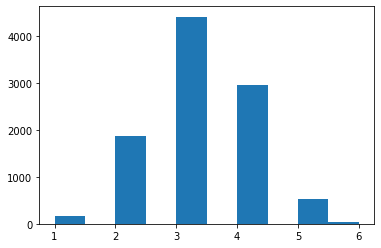

In [20]:
plt.hist(preds.cpu().numpy() + 1);  # to adjust labels